#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Améliorer les performances du réseau de neurones

 **Objectif d'apprentissage :** Améliorer les performances d'un réseau de neurones en normalisant des caractéristiques et en appliquant différents algorithmes d'optimisation

**REMARQUE :** Les méthodes d'optimisation décrites dans cet exercice ne sont pas propres aux réseaux de neurones ; elles peuvent, en effet, servir à améliorer la plupart des types de modèles.

 ## Configuration

Vous allez commencer par charger les données.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [14]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2651.6,539.8,1432.6,501.8,3.9,2.0
std,2.1,2.0,12.6,2205.8,421.6,1162.3,385.1,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,297.0,793.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2134.0,434.0,1169.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3156.2,651.0,1721.2,605.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,41.3


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.8,2624.7,538.6,1422.4,499.8,3.9,2.0
std,2.1,2.0,12.5,2116.6,421.2,1112.5,383.1,1.9,1.4
min,32.5,-124.2,2.0,8.0,1.0,13.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1452.0,296.0,781.0,281.0,2.5,1.5
50%,34.3,-118.5,29.0,2118.0,432.5,1159.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3129.8,644.0,1720.2,606.0,4.7,2.3
max,41.9,-114.3,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.6
std,115.8
min,15.0
25%,119.4
50%,181.2
75%,265.6
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.6
std,116.5
min,15.0
25%,119.8
50%,177.8
75%,264.1
max,500.0


 ## Entraîner le réseau de neurones

Vous allez ensuite entraîner le réseau de neurones.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 167.63
  period 01 : 165.05
  period 02 : 158.04
  period 03 : 155.15
  period 04 : 140.52
  period 05 : 122.14
  period 06 : 110.92
  period 07 : 107.45
  period 08 : 106.40
  period 09 : 106.31
Model training finished.
Final RMSE (on training data):   106.31
Final RMSE (on validation data): 107.93


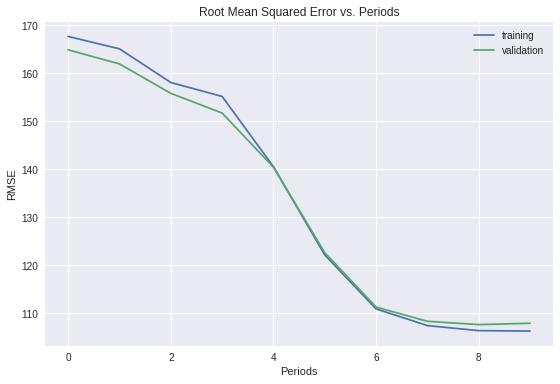

In [18]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Mise à l'échelle linéaire
Il peut être judicieux de normaliser les entrées pour qu'elles soient comprises entre -1 et 1. Cela permet d'éviter au SGD de sélectionner des mesures qui sont trop grandes dans une dimension ou trop petites dans une autre. Dans le cas présent, les partisans de l'optimisation numérique remarqueront peut-être le lien avec l'utilisation d'un préconditionneur.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

 ## Tâche 1 : Utiliser la mise à l'échelle linéaire pour normaliser les caractéristiques

**Normalisez les entrées sur l'échelle -1, 1.**

**Consacrez environ cinq minutes à l'apprentissage et à l'évaluation des dernières données normalisées. Comment vous en sortez-vous ?**

En règle générale, l'apprentissage des réseaux de neurones est plus performant lorsque les caractéristiques d'entrée se situent grosso modo sur la même échelle.

Évaluez l'intégrité de vos données normalisées. (Que se passerait-il si vous oubliiez de normaliser une caractéristique ?)


Training model...
RMSE (on training data):
  period 00 : 232.56
  period 01 : 211.59
  period 02 : 165.21
  period 03 : 115.32
  period 04 : 113.15
  period 05 : 111.78
  period 06 : 110.69
  period 07 : 109.76
  period 08 : 109.08
  period 09 : 108.54
Model training finished.
Final RMSE (on training data):   108.54
Final RMSE (on validation data): 109.35


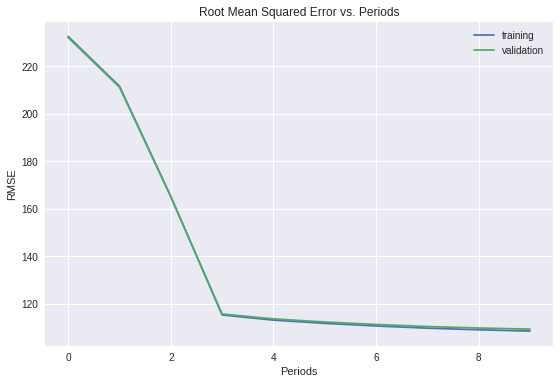

In [20]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  return examples_dataframe.apply(linear_scale, axis = 1)

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Étant donné que les valeurs minimale et maximale sont utilisées dans le cadre de la normalisation, vous devez vous assurer que cette opération est effectuée sur l'intégralité de l'ensemble de données en une seule fois. 

Cela est possible ici, car toutes les données se trouvent dans un seul DataFrame. S'il y avait plusieurs ensembles de données, une bonne pratique consisterait à dériver les paramètres de normalisation de l'ensemble d'apprentissage et à les appliquer de manière identique à l'ensemble d'évaluation.

Training model...
RMSE (on training data):
  period 00 : 174.41
  period 01 : 114.55
  period 02 : 103.39
  period 03 : 87.50
  period 04 : 77.40
  period 05 : 74.59
  period 06 : 72.98
  period 07 : 71.81
  period 08 : 70.84
  period 09 : 70.72
Model training finished.
Final RMSE (on training data):   70.72
Final RMSE (on validation data): 73.32


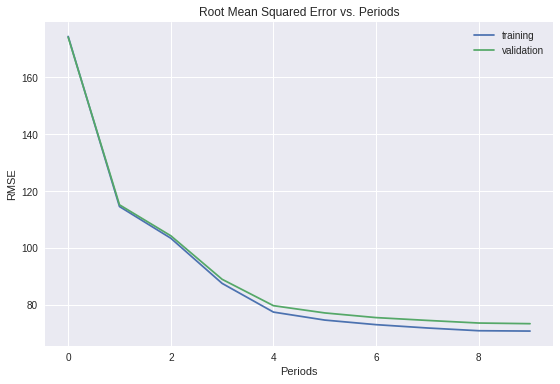

In [21]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## Tâcher 2 : Essayer un autre optimiseur

** Utilisez les optimiseurs AdaGrad et Adam, et comparez leurs performances.**

L'optimiseur AdaGrad constitue une solution. L'idée principale est que cet optimiseur adapte le taux d'apprentissage pour chaque coefficient d'un modèle, en réduisant, de façon monotone, le taux d'apprentissage effectif. Cette méthode fonctionne parfaitement pour les problèmes convexes, mais elle ne s'avère pas toujours idéale pour le problème non convexe d'entraînement des réseaux de neurones. Vous pouvez utiliser AdaGrad en indiquant `AdagradOptimizer` au lieu de `GradientDescentOptimizer`. Notez qu'un taux d'apprentissage plus élevé peut être nécessaire avec AdaGrad.

Pour les problèmes d'optimisation non convexes, Adam se révèle parfois plus efficace. Pour utiliser Adam, invoquez la méthode `tf.train.AdamOptimizer`. Cette méthode utilise plusieurs hyperparamètres facultatifs en tant qu'arguments, mais notre solution n'en spécifie qu'un seul (`learning_rate`). Dans un environnement de production, vous devez être prudent lorsque vous spécifiez et réglez les hyperparamètres facultatifs.

Training model...
RMSE (on training data):
  period 00 : 115.47
  period 01 : 90.04
  period 02 : 71.56
  period 03 : 69.84
  period 04 : 69.06
  period 05 : 68.40
  period 06 : 68.77
  period 07 : 68.55
  period 08 : 67.65
  period 09 : 66.86
Model training finished.
Final RMSE (on training data):   66.86
Final RMSE (on validation data): 69.81


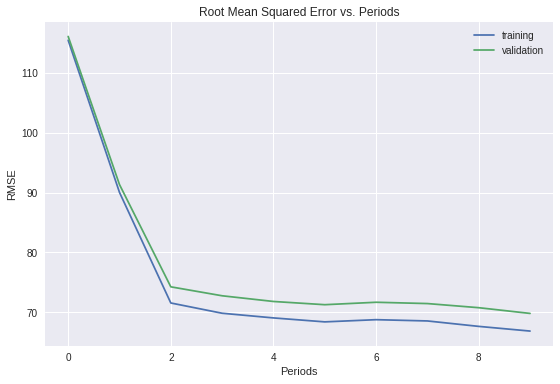

In [22]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.
#
_ = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher la solution.

 Essayez tout d'abord l'algorithme AdaGrad.

Training model...
RMSE (on training data):
  period 00 : 92.75
  period 01 : 76.65
  period 02 : 71.28
  period 03 : 71.07
  period 04 : 70.54
  period 05 : 69.01
  period 06 : 68.43
  period 07 : 68.54
  period 08 : 69.68
  period 09 : 70.31
Model training finished.
Final RMSE (on training data):   70.31
Final RMSE (on validation data): 72.92


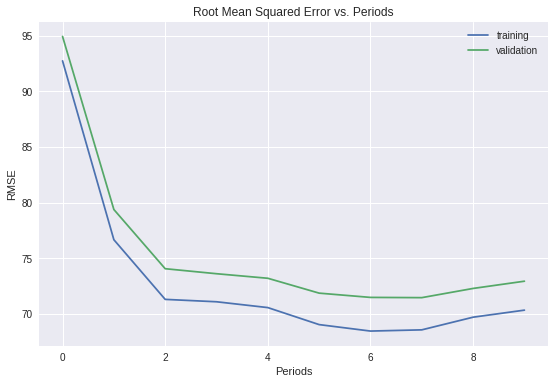

In [23]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 Essayez maintenant Adam.

Training model...
RMSE (on training data):
  period 00 : 220.28
  period 01 : 120.42
  period 02 : 114.00
  period 03 : 104.49
  period 04 : 92.23
  period 05 : 76.42
  period 06 : 71.83
  period 07 : 70.40
  period 08 : 69.88
  period 09 : 69.44
Model training finished.
Final RMSE (on training data):   69.44
Final RMSE (on validation data): 72.07


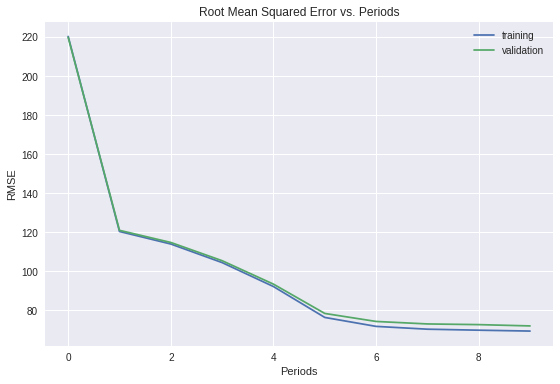

In [24]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 Imprimez un graphique qui affiche les mesures de perte côte à côte.

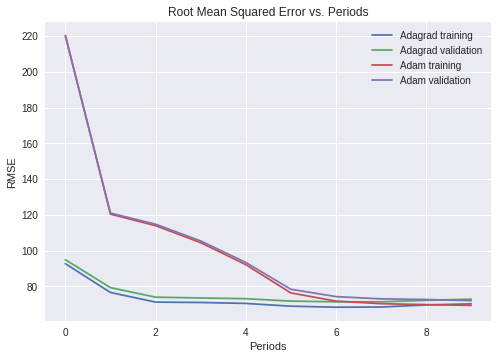

In [25]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

 ## Tâche 3 : Explorer d'autres méthodes de normalisation

**Essayez d'autres normalisations pour différentes caractéristiques afin d'optimiser les performances.**

Si vous observez attentivement les statistiques récapitulatives de vos données transformées, vous remarquerez peut-être que la mise à l'échelle linéaire de certaines caractéristiques les laisse regroupées dans le voisinage de `-1`.

Par exemple, de nombreuses caractéristiques ont une médiane d'à peu près `-0.8`, plutôt que `0.0`.

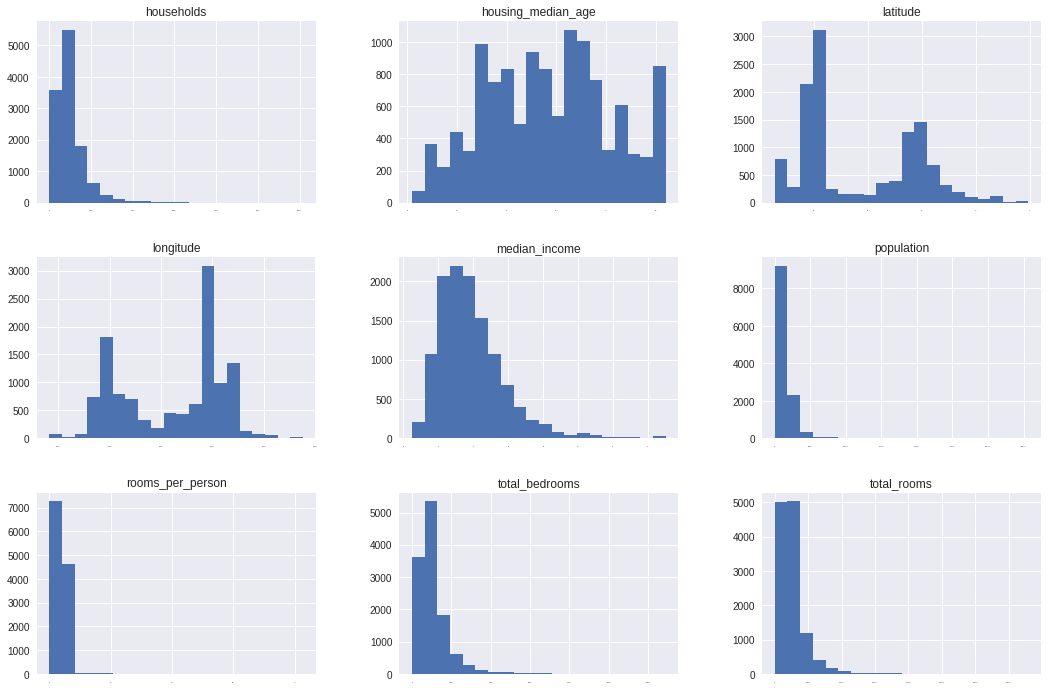

In [26]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

 Il est possible d'obtenir un meilleur résultat en choisissant d'autres méthodes pour transformer ces caractéristiques.

Une mise à l'échelle logarithmique, par exemple, peut être intéressante pour certaines caractéristiques. Quant à l'élimination des valeurs extrêmes, elle permettra peut-être de rendre plus instructif le reste de l'échelle.

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

 Le bloc ci-dessus contient quelques fonctions de normalisation supplémentaires. Essayez-en quelques-unes ou ajoutez les vôtres.

Notez que si vous normalisez la cible, vous devrez annuler la normalisation des prédictions pour que les mesures de perte soient comparables.

Training model...
RMSE (on training data):
  period 00 : 234.14
  period 01 : 223.62
  period 02 : 199.60
  period 03 : 157.23
  period 04 : 101.71
  period 05 : 80.01
  period 06 : 77.00
  period 07 : 75.37
  period 08 : 74.48
  period 09 : 73.96
Model training finished.
Final RMSE (on training data):   73.96
Final RMSE (on validation data): 76.25


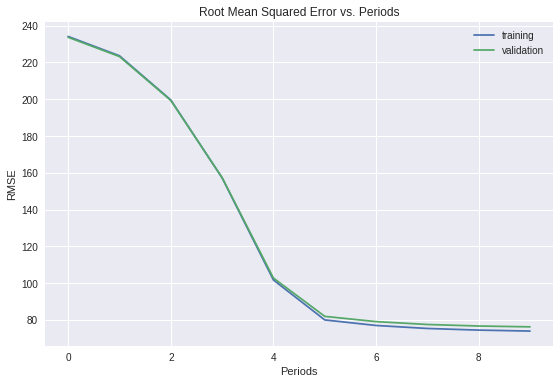

In [29]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = z_score_normalize(examples_dataframe["households"])
  processed_features["median_income"] = z_score_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = z_score_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Il ne s'agit là que d'un bref aperçu des méthodes qui peuvent être utilisées pour prendre en compte les données. D'autres transformations peuvent se révéler encore plus efficaces !

Les valeurs `households`, `median_income` et `total_bedrooms` apparaissent toutes comme étant normalement distribuées dans un espace logarithmique.

Dans le cas des valeurs `latitude`, `longitude` et `housing_median_age`, il serait sans doute préférable qu'elles soient mises à l'échelle de façon linéaire, comme précédemment.

`population`, `totalRooms` et `rooms_per_person` présentent quelques anomalies extrêmes. Elles semblent trop extrêmes pour que la normalisation logarithmique ne soit d'une quelconque utilité. Il est donc préférable de les éliminer.

Training model...
RMSE (on training data):
  period 00 : 86.30
  period 01 : 78.75
  period 02 : 74.29
  period 03 : 72.67
  period 04 : 71.47
  period 05 : 71.29
  period 06 : 70.37
  period 07 : 70.86
  period 08 : 70.33
  period 09 : 69.25
Model training finished.
Final RMSE (on training data):   69.25
Final RMSE (on validation data): 72.41


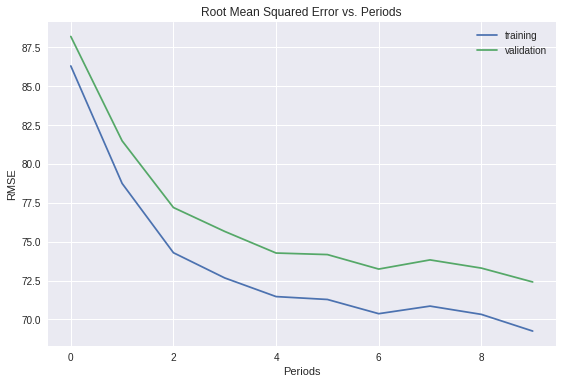

In [30]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

 ## Exercice facultatif : Utiliser uniquement les caractéristiques Latitude et Longitude

**Entraînez un modèle de réseau de neurones qui utilise seulement la latitude et la longitude comme caractéristiques.**

Les agents immobiliers ont coutume de dire que l'emplacement est la seule caractéristique importante dans le prix d'un logement.
Voyons si cela se confirme en entraînant un modèle qui utilise uniquement la latitude et la longitude comme caractéristiques.

Cela ne fonctionnera correctement que si le réseau de neurones peut apprendre des non-linéarités complexes à partir de la latitude et de la longitude.

**REMARQUE :** Vous aurez peut-être besoin d'une structure de réseau comportant davantage de couches que ce qui était nécessaire précédemment.

In [0]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Il est conseillé de faire en sorte que la latitude et la longitude restent normalisées :

Training model...
RMSE (on training data):
  period 00 : 111.62
  period 01 : 105.70
  period 02 : 102.94
  period 03 : 101.85
  period 04 : 100.66
  period 05 : 100.19
  period 06 : 100.01
  period 07 : 99.58
  period 08 : 99.04
  period 09 : 99.01
Model training finished.
Final RMSE (on training data):   99.01
Final RMSE (on validation data): 100.93


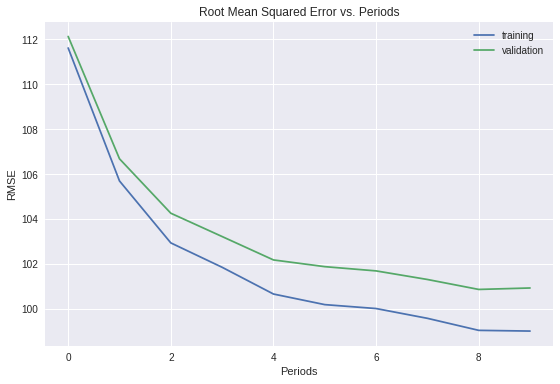

In [31]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

 C'est acceptable lorsqu'il n'y a que deux caractéristiques. Toutefois, il va sans dire que les prix des propriétés peuvent varier sensiblement sur de courtes distances.